In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# hack to import files from parent directory
import os
import sys
upper_dir = os.path.abspath(os.path.join('..'))
if upper_dir not in sys.path:
    sys.path.append(upper_dir)
    

# packages existing in parent directory
from Feedforward.feedforward import Feedforward
import utils.ntk_lib as ntk_lib

In [2]:
width = 1000
output_d = 1
bias=True

In [ ]:
# Import the CIFAR10, and MNIST datasets and prepare dataloader
batch_size = 1000

cifar_data_train = datasets.CIFAR10('../data/cifar10',
                      train=True,
                      download=True,
                      transform=transforms.Compose([
                          transforms.Resize((32, 32)),
                          transforms.ToTensor(),
                          transforms.Lambda(torch.flatten)]))

mnist_data_train = datasets.MNIST('../data/mnist',
                      train=True,
                      download=True,
                      transform=transforms.Compose([
                          transforms.Resize((32, 32)),
                          transforms.ToTensor(),
                          transforms.Lambda(torch.flatten)]))

cifar_train_loader = DataLoader(cifar_data_train, batch_size=batch_size, shuffle=True, num_workers=2)
mnist_train_loader = DataLoader(mnist_data_train, batch_size=batch_size, shuffle=True, num_workers=2)

# Get a new batch
cifar_data, cifar_targets = next(iter(cifar_train_loader))
mnist_data, mnist_targets = next(iter(mnist_train_loader))

Files already downloaded and verified


/Users/benjaminbowman/miniconda3/envs/functoolstorch/lib/python3.10/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


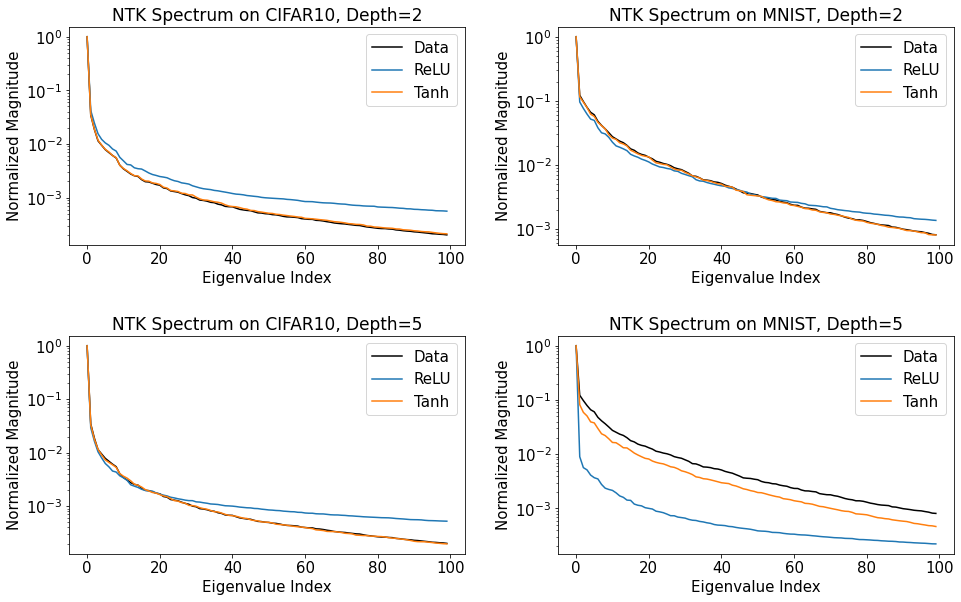

In [4]:
fig, axs = plt.subplots(2, 2)
plt.yscale('log')

depths = [2, 5]
acts = [torch.nn.functional.relu, torch.nn.functional.tanh]
act_name = ['ReLU', 'Tanh']
dataset_names=['CIFAR10', 'MNIST']
data_list = [cifar_data, mnist_data]

stop_index = 100

for i, data in enumerate(data_list):
    data_gram = data @ data.T
    data_eigs = np.linalg.eigvalsh(data_gram)
    data_eigs_reversed_sorted = np.sort(data_eigs)[::-1]
    data_max_eig = data_eigs_reversed_sorted[0]
    for j, depth in enumerate(depths):
        axs[j][i].semilogy(data_eigs_reversed_sorted[:stop_index] / data_max_eig, color='k', label='Data')
        axs[j][i].tick_params(axis='both', labelsize=15)
        axs[j][i].set_ylabel('Normalized Magnitude', fontsize=15)
        axs[j][i].set_xlabel('Eigenvalue Index', fontsize=15)
        for k, act in enumerate(acts):
            # initialize network
            input_d = data.shape[-1]
            net = Feedforward(width, input_d, output_d, act, depth, bias)

            # Compute NTK
            ntk = ntk_lib.ntk(net, data)

            # Compute eigenvalues for the NTK
            eigs = np.linalg.eigvalsh(ntk)
            eigs_reversed_sorted = np.sort(eigs)[::-1]
            max_eig = eigs_reversed_sorted[0]

            # Add the normalized spectrum to the plot
            axs[j][i].semilogy(eigs_reversed_sorted[:stop_index] / max_eig, label=act_name[k])
            axs[j][i].legend(loc='upper right', prop={'size': 15})
            

            axs[j][i].set_title('NTK Spectrum on {}, Depth={}'.format(dataset_names[i], depth), fontsize=17)

fig.set_size_inches(14, 9)
fig.tight_layout(pad=3.0)

In [5]:
fig.savefig('spectrum_plots.png')